# Coffee Shop Geeking

### Import statements for visualization, processing, and JSON utilities

In [39]:
import folium
import requests
import matplotlib.pyplot as plt
import json
import pandas as pd

### GPS points are centroids of major cities in NCR

Foursquare has this weird rate limit that caps my query radius despite having a 40km setting in the GET request. I'll need to work on that. In the meantime, here's a hack to get the ball rolling.

In [2]:
places = ["14.73371, 121.06813", "14.73554, 121.01268", "14.72026, 120.96342", \
          "14.6922, 121.06212", "14.69037, 121.01732", "14.68954, 120.97063", \
          "14.65517, 121.05182", "14.65866, 121.01028", "14.64703, 120.9708", \
          "14.6364, 121.07414", "14.64819, 121.1174", "14.62361, 121.03998", \
          "14.61049, 120.9914", "14.60949, 121.10658", "14.60152, 121.05165", \
          "14.56946, 121.09491", "14.5776, 121.05972", "14.5771, 121.02865", \
          "14.5565, 121.02092", "14.55583, 121.02607", "14.55583, 121.02607", \
          "14.55002, 121.06126", "14.55002, 121.04581", "14.5241, 121.02127", \
          "14.47723, 121.02521", "14.44631, 121.00221", "14.40209, 121.02779",
          "14.40209, 121.02779", "14.60974, 121.08002", "14.64969, 121.0747"]
topics = ["coffee", "cafe", "coffee shop", "coffeeshop", "Coffee Shop", "Coffeeshop", "Coffee", "Cafe"]

### Foursquare GET request template

It's a bit inefficient due to the nested list comprehension going on. I'm actually iterating through each place, and each topic here--like a double for loop. This way I can scrape each location with radius 40km for each topic I've set.

When running this, I recommend brewing a nice pour over. **This will take a while.**

In [3]:
response = [json.loads(requests.get("https://api.foursquare.com/v2/venues/search?"
      "client_id=YOUR_CLIENT_ID"
      "client_secret="YOUR_SECRET_KEY"&"
      "ll=" + place +"&"
      "v=20140806&"
      "query=" + topic + "&"
      "intent=browse&"
      "radius=40000&"
      "limit=50&"
      "categoryId=4bf58dd8d48988d1e0931735"
      ).text)["response"] for place in places for topic in topics]
len(response)

240

### Conversion of JSON response to Pandas Dataframe


The duplicates are dropped to cut down on data volume and column headers are set here. There's a quick value_counts check there just to see which ones are the top.

In [70]:
data_list = []
for x in range(len(response)):
    try:
        for i in range(len(response[x]["venues"])):
            poi_id =  response[x]["venues"][i]["id"]
            poi_name =  response[x]["venues"][i]["name"]
            poi_lat =  response[x]["venues"][i]["location"]["lat"]
            poi_lng =  response[x]["venues"][i]["location"]["lng"]
            data_list.append([poi_id, poi_name, poi_lat, poi_lng])
    except KeyError:
        pass

df = pd.DataFrame(data_list, columns=["id", "name", "lat", "lng"])
df = df.drop_duplicates()
df["name"] = df['name'].str.lower()

### Plot the frequency of the top 20 coffeeshops

I tried using Bokeh here initially, but the dataframe comes with a built-in matplotlib plotting utility, so here's how that's done. 

We can see that Starbucks has 159 branches, with CBTL just at 35. There seems to be something off with that. CBTL's website has more than 35 branches within the NCR. This is probably a hitch with Foursquare's labelling or classification. Either way, I'll have to get back to that. 

I did a check and saw that there are nuances with the naming of some coffeeshop chains. I'm doing a simple string check here, so I'll have to roll my own counting algorithm for the shops.

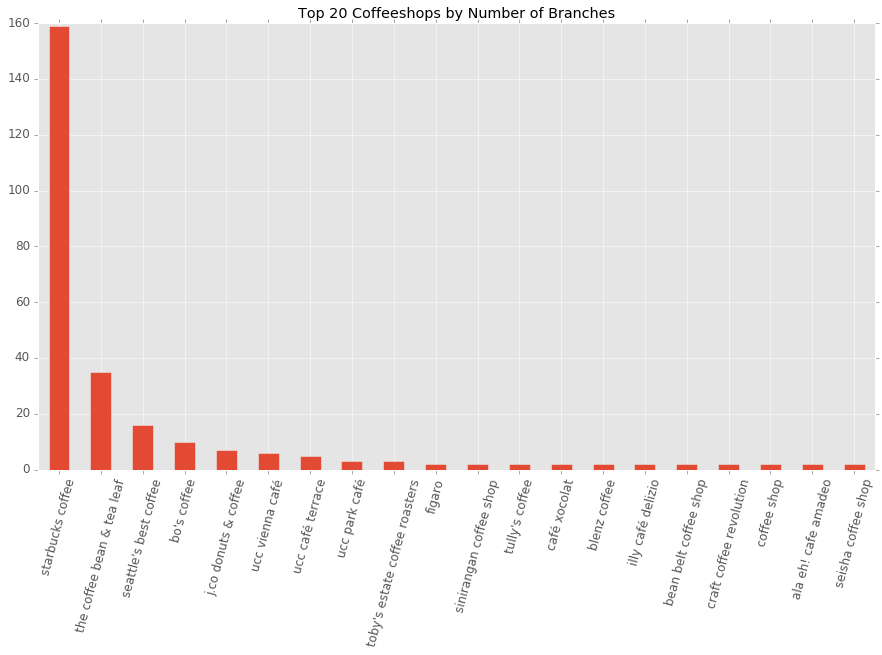

In [76]:
fig, ax = plt.subplots()
df['name'].value_counts().head(20).plot(ax=ax, kind='bar', \
                                        title ="Top 20 Coffeeshops by Number of Branches",figsize=(15,8), fontsize=12, rot=75)

** Plotting the coffee shop locations with Folium**

I personally like using Mapbox's dark basemap for personal projects. It gives it a very modern and minimal feel. The locations are plotted with yellow circles with a slight transparency going on.

In [5]:
tileset =r'https://api.tiles.mapbox.com/v4/mapbox.dark/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiZnJhbmNpc2JhdXRpc3RhIiwiYSI6ImNpZnN3aXNhbzBiZDh1amx4YTVwODliY2QifQ.Du-sSfOon7A7Jk-1AmM41w'
attribution=r'Map data © <a href="http://openstreetmap.org">OpenStreetMap</a> contributors, Imagery ©'
basemap = folium.Map(location=[14.5562297,121.0204097], height=1000, width=1000, tiles=tileset, zoom_start=15, attr=attribution)
for index, row in df.iterrows():
    basemap.circle_marker(location=[row["lat"], row["lng"]], radius=20,
                    popup=row["name"], line_color='#FFDB51', fill_color='#FFDB51')

basemap

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: circle_marker is deprecated. Use add_children(CircleMarker) instead
